In [1]:
!nvidia-smi

Wed Aug 14 20:32:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   43C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \
supervision==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 25.4 MB/s eta 0:00:00


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


# Global Image Directory

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!unzip /content/drive/MyDrive/Dataset_Images.zip -d /content/drive/MyDrive/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Dataset_Images/3120_town_05_part_00_night_right_rear.png  
  inflating: /content/drive/MyDrive/Dataset_Images/1968_town_01_part_00_night_right_forward.png  
  inflating: /content/drive/MyDrive/Dataset_Images/3781_town_04_part_00_night_front_fisheye.png  
  inflating: /content/drive/MyDrive/Dataset_Images/2871_town_05_part_00_night_front_wide.png  
  inflating: /content/drive/MyDrive/Dataset_Images/5320_town_03_part_00_night_front_fisheye.png  
  inflating: /content/drive/MyDrive/Dataset_Images/3950_town_04_part_00_night_right_forward.png  
  inflating: /content/drive/MyDrive/Dataset_Images/2201_town_01_part_00_night_left_forward.png  
  inflating: /content/drive/MyDrive/Dataset_Images/4225_town_04_part_00_night_left_forward.png  
  inflating: /content/drive/MyDrive/Dataset_Images/1143_town_06_part_00_midday_right_forward.png  
  inflating: /content/drive/MyDrive/Dataset_Images/5434_town_03_part_00_ni

In [4]:
IMAGE_DIR_PATH = f"{HOME}/drive/MyDrive/Dataset_Images"

# Display Image samples

In [5]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 6400


In [6]:
SAMPLE_SIZE = 9
SAMPLE_GRID_SIZE = (3, 3)
SAMPLE_PLOT_SIZE = (16, 16)

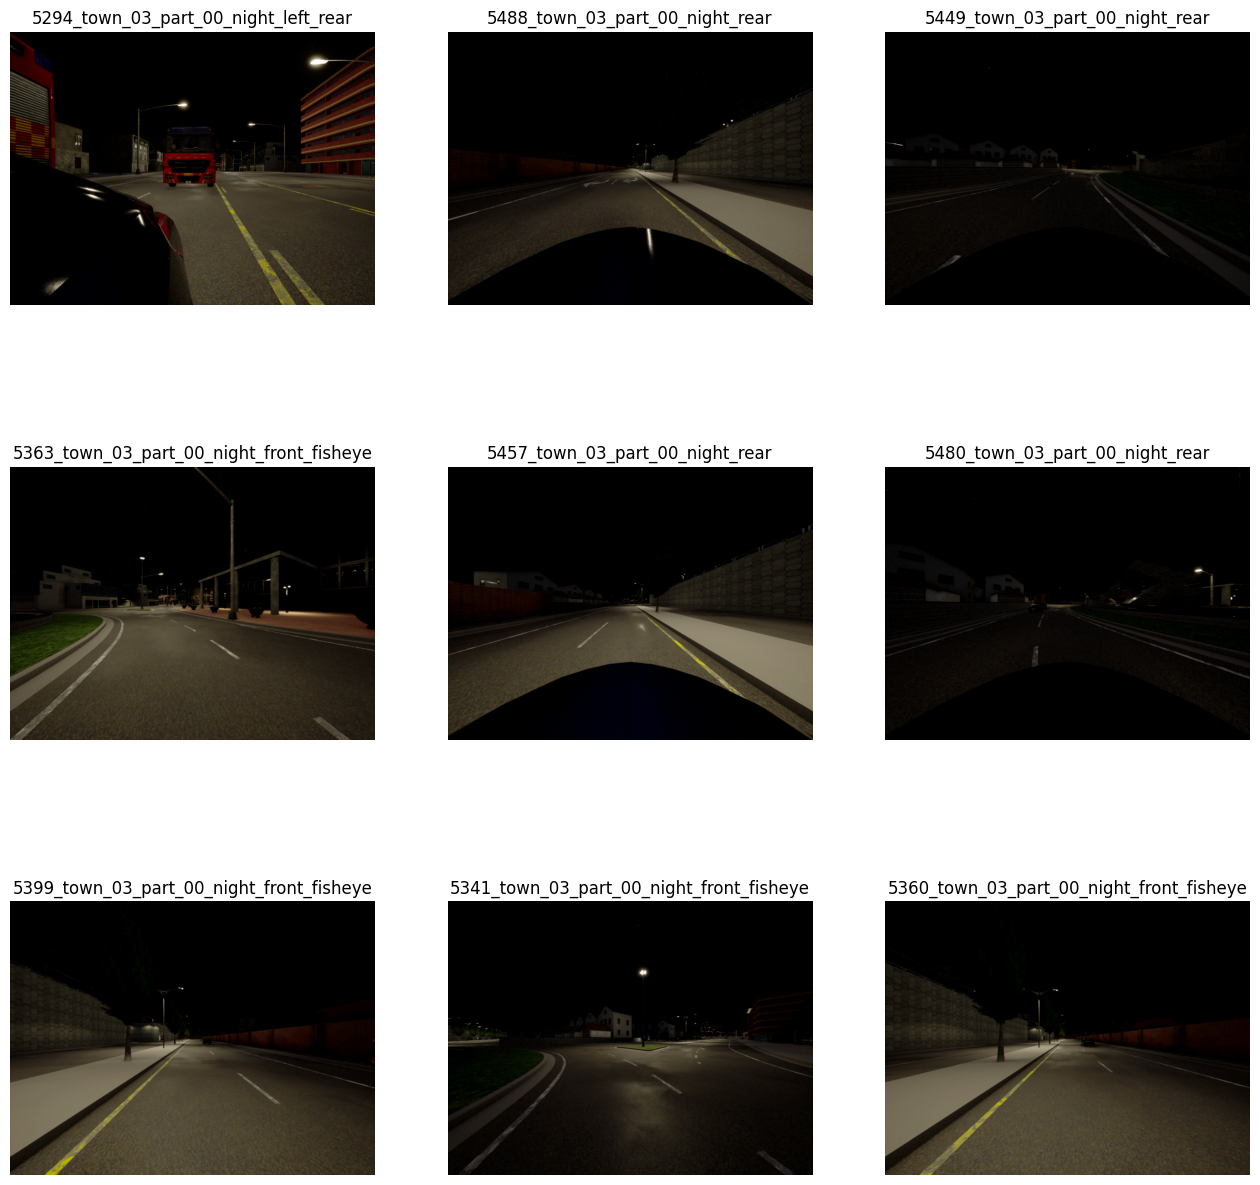

In [7]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [8]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "Cars, trucks, buses, motorcycles, bicycles,": "Vehicle",
    "People walking, running, or standing": "Pedestrian",
    "Stop signs, speed limit signs": "Traffic_Signs",
    "traffic lights, traffic signals":"traffic_light"
})

# For a stricter ontology follow following mapping
- Use one of them during labeling

In [ ]:
from autodistill.detection import CaptionOntology

ontology = CaptionOntology({
    "Car": "Vehicle",
    "Truck": "Vehicle",
    "Bus": "Vehicle",
    "Motorcycle": "Vehicle",
    "Bicycle": "Vehicle",
    "Person walking": "Pedestrian",
    "Person running": "Pedestrian",
    "Person standing": "Pedestrian",
    "Stop sign": "Traffic_Sign",
    "Speed limit sign": "Traffic_Sign",
    "Traffic light": "Traffic_Light",
    "Traffic signal": "Traffic_Light"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [11]:
DATASET_DIR_PATH = f"{HOME}/drive/MyDrive/dataset_carla"

In [12]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/drive/MyDrive/Dataset_Images/0417_town_01_part_00_morning_front_wide.png: 100%|██████████| 6400/6400 [7:31:45<00:00,  4.24s/it]


Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [ ]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/drive/MyDrive/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/drive/MyDrive/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/drive/MyDrive/dataset/data.yaml"

In [ ]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

In [ ]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)